# Development and Examples for mvpolyfit and gmvfit
(Lionel London 2016, email: lionel.london@ligo.org)

In [6]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Import useful things
from kerr import rgb,alert,leaver,mvpolyfit,ndflatten,mvsyms,gmvpfit
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
from numpy import *
from numpy.linalg import pinv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Low Level Development Cell: Create an algorithm that performs N-D polynomial fits using basic least-squares regression via pseudo-inverse

['0', '00', '1', '11']
the pseudo-inverse shape is: [5, 100]
the scalar range shape is:[100]
[  9.64761967e-05   1.90777102e-02   1.01626762e+00  -9.24877130e-03
   9.95884567e-01]
f = 0.0001*(1) + 1.9078e-02*(x) + 1.0163e+00*(x*x) + -9.2488e-03*(y) + 9.9588e-01*(y*y)
stdres = 2.536016e-02
(100, 2)


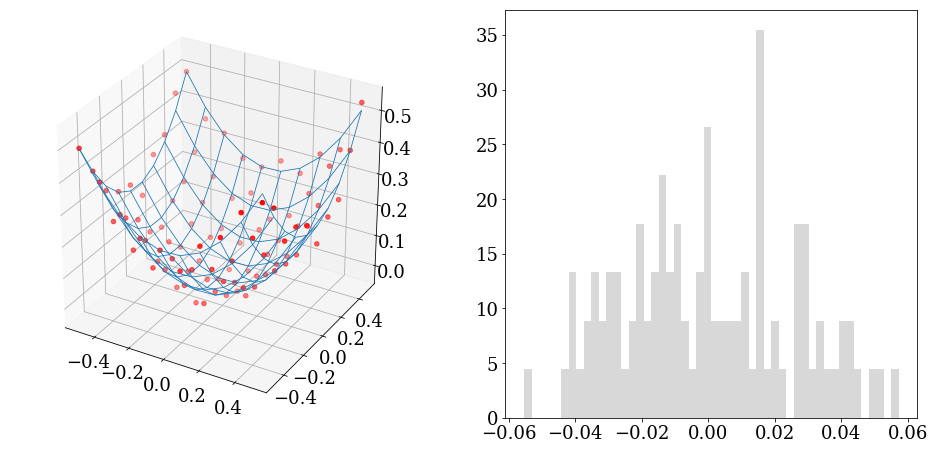

In [7]:
# Create cludge 3d surface
fig = figure( figsize=2.5*array([6.5,3]) )
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

x = linspace(-0.5,0.5,10)
y = array(x)
D = 2

# print x.shape

X,Y = meshgrid(x,y)

zfun = lambda xx,yy: xx**2 + yy**2
Z = zfun(X,Y) + 0.1*(random.random( X.shape )-0.5)

#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#%%#

# N-D to 1D
#--
# Domain
flatX = reshape( X, (X.size,) )
flatY = reshape( Y, (Y.size,) )
# Range
flatZ = reshape( Z, (Z.size,) )

# 
domain = vstack( [flatX,flatY] ).T
scalar_range = flatZ

# print domain.shape 
# print scalar_range.shape 

#                 x   y   x*x  y*y
basis_symbols = ['0','1','00','11']

# Cleanly format basis symbols, and remove possible duplicates, or linearly dependent symbols 
for s in basis_symbols:
    s = sorted(s)
basis_symbols = sorted( list( set(basis_symbols) ) )
print basis_symbols
# print len(basis_symbols)

# Each symbol encodes a function of the basis vectors. 
# NOTE that a constant term will be added independently of the given symbols, unless as toggle is implemented?
def C( sym, dom = None ):
    if dom is None:
        dom = domain
    map_ = [ int(k) for k in sym ]
    ans = 1.0 # NOTE that the final answer will be of the shape of the domain vectors
    for k in map_:
        ans *= dom[:,k]
    #
    return ans
        
P = vstack( [ ones( C('0').shape ), [C(sym) for sym in basis_symbols] ] ).T

# print P.shape

# raise

# Compute the pseudo inverse of P
Q = pinv( P )

print 'the pseudo-inverse shape is: %s' % list(Q.shape)
print 'the scalar range shape is:%s' % list(scalar_range.shape)

# Estimate the coefficients of the basis symbols
a = dot( Q, scalar_range )

print a

# Create a functional representation of the fit
# fun = lambda vec: a[0]*ones(C('0').shape) + sum( [ b*C(basis_symbols[k],dom=vec) for k,b in enumerate(a[1:]) ] )
def fun( vec ):
    ans_str = 'f = '
    # constant term
    ans = a[0]*ones(C('0', dom=vec).shape)
    ans_str += '%1.4f*(1)' % a[0]
    #
    for k,b in enumerate(a[1:]):
        ans += b*C( basis_symbols[k], dom=vec )
        ans_str += ' + %1.4e*(%s)' % (b,basis_symbols[k].replace('0','*x').replace('1','*y'))
    return (ans,ans_str.replace('(*','('))

# Compute the fit residuals
residuals = std( fun( domain )[0] - scalar_range )

print fun( domain )[1]
print 'stdres = %e' % residuals

x2 = linspace(-0.5,0.5,10) 
y2 = linspace(-0.5,0.5,10) 
X2,Y2 = meshgrid(x2,y2)
flatX2 = reshape( X2, (X2.size,) )
flatY2 = reshape( Y2, (Y2.size,) )
domain2 = vstack( [flatX2,flatY2] ).T
print domain2.shape
flastZ2 = fun( domain2 )[0]
Z2 = flastZ2.reshape( X2.shape )
        
# ax.scatter(X,Y,Z)
ax.plot_wireframe(X2, Y2, Z2, rstride=1, cstride=1)
ax.scatter(X,Y,Z,color='r')

res = fun( domain )[0] - scalar_range
n, bins, patches = ax2.hist(res, 50, normed=1, facecolor=0.8*array([1,1,1]), alpha=0.75)

# ax2.plot( , 'or', mec='none',alpha=0.8 )
# ax2.axhline( 0, color='b' )

show()

# Use the packaged code version -- 4D example

In [8]:
close('all')
x0 = linspace(-0.5,0.5,15)
y0 = array(x0)
u0 = array(x0)
x = x0 + 0.08*(random.random( x0.shape )-0.5)
y = y0 + 0.08*(random.random( y0.shape )-0.5)
u = u0 + 0.08*(random.random( y0.shape )-0.5)
X,Y,U = meshgrid(x,y,u)
zfun = lambda xx,yy,uu: xx**2 + yy**2 + xx*yy + uu*uu

Z = zfun(X,Y,U) + 0.01*(random.random( X.shape )-0.5)

#
domain,scalar_range = ndflatten( [X,Y,U], Z )

foo = mvpolyfit( domain,
                scalar_range,
                ['00','11','01','22'],
                plot = True,
                verbose = True
               )
print foo

f = lambda x0,x1,x2: 1.0007e+00*(x1*x1) + 9.9971e-01*(x0*x0) + 9.9984e-01*(x0*x1) + 1.0005e+00*(x2*x2)


/Library/Python/2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Python/2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/book/JOKI/Libs/KOALA/positive_dev/positive/learning.py:1258: RuntimeWarning: invalid value encountered in divide
  phares = ( sunwrap(angle(fit_range)) - sunwrap(angle(this.range)) ) / sunwrap(angle(this.range))


In [9]:
print X.shape

(15, 15, 15)


# 3D Example

In [10]:
close('all')
x0 = linspace(-0.5,0.5,15)
y0 = array(x0)
u0 = array(x0)
x = x0 + 0.08*(random.random( x0.shape )-0.5)
y = y0 + 0.08*(random.random( y0.shape )-0.5)
X,Y = meshgrid(x,y)
zfun = lambda xx,yy: xx**2 + yy**2 + xx*yy

Z = zfun(X,Y) + 0.1*(random.random( X.shape )-0.5)

#
domain,scalar_range = ndflatten( [X,Y], Z )

foo = mvpolyfit( domain,
                scalar_range,
                ['00','11','01'],
                plot = True,
                verbose = True
               )
print foo

f = lambda x0,x1: 9.9626e-01*(x1*x1) + 9.7957e-01*(x0*x0) + 9.6063e-01*(x0*x1)


# Consider the space of possibly model symbols given a domain domension, and maximum order to be considered for modeling (towards the greedy selection of models)

In [11]:
# Create the symbols for polynomial terms in 1D domain up to 6th power
# Symbolically, the output is equivalent to function model of the form: f(x) = sum( [ x**k for k in arange(6+1) ] )
# NOTE that "K" is understood by mvpolyfit to be a constant term
x,y = 1,6
print mvsyms( dimension=x, max_degree=y, verbose=False )

['K', '0', '00', '000', '0000', '00000', '000000']


In [12]:
# Create the symbols for polynomial terms in 2D domain up to 2nd power
x,y = 2,2
print mvsyms( dimension=x, max_degree=y, verbose=False )

['K', '0', '1', '00', '01', '11']


In [13]:
# Create the symbols for polynomial terms in 4D domain up to 2nd power
x,y = 4,2
print mvsyms( dimension=x, max_degree=y, verbose=False )

['K', '0', '1', '2', '3', '00', '01', '02', '03', '11', '12', '13', '22', '23', '33']


In [14]:
# Create the symbols for polynomial terms in 3D domain up to 6nd power
x,y = 3,6
print mvsyms( dimension=x, max_degree=y, verbose=False )

['K', '0', '1', '2', '00', '01', '02', '11', '12', '22', '000', '001', '002', '011', '012', '022', '111', '112', '122', '222', '0000', '0001', '0002', '0011', '0012', '0022', '0111', '0112', '0122', '0222', '1111', '1112', '1122', '1222', '2222', '00000', '00001', '00002', '00011', '00012', '00022', '00111', '00112', '00122', '00222', '01111', '01112', '01122', '01222', '02222', '11111', '11112', '11122', '11222', '12222', '22222', '000000', '000001', '000002', '000011', '000012', '000022', '000111', '000112', '000122', '000222', '001111', '001112', '001122', '001222', '002222', '011111', '011112', '011122', '011222', '012222', '022222', '111111', '111112', '111122', '111222', '112222', '122222', '222222']


## Notes:

* The function ```mvsyms()``` and dependents just may constitute an interesting solution to the subset sum problem
* The purpose of ```mvsyms``` is to provide a dictionary (aka bulk) for a greedy algorithm to act upon and collect a subset (aka boundary)
* Interesting question: How does the number of possible symbols scale with domain dimension and maximum polynomial degree?

### Plot the number of symbols on increasing max degree

Text(0.5,1,u'Domain Dimension = 3')

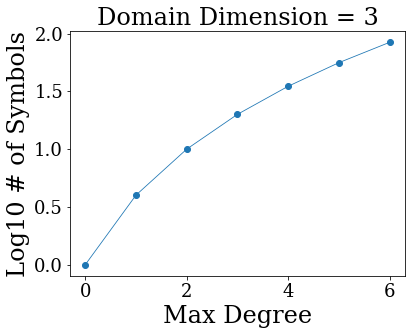

In [15]:
deg_range = arange(7)
dd = 3
y = []
for deg in deg_range:
    y.append( len( mvsyms( dimension=dd, max_degree=deg, verbose=False ) ) )
figure(figsize=1.5*array([4,3]))
plot( deg_range, log10(y), '-o' )
xlabel('Max Degree')
ylabel('Log10 # of Symbols')
title('Domain Dimension = %i'%dd)

### Plot the hold the number of symbols (possible model terms) behaves with domain dimension (max order) and max degree

(7, 7)


Text(0.5,0,u'Log10 # of Symbols')

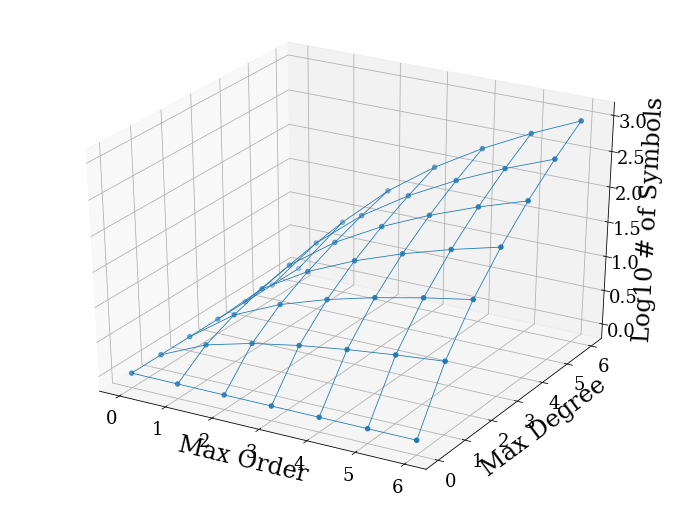

In [16]:
%matplotlib inline
X = arange(7) # Dimension of domain
Y = arange(7) # Max polynomial order
XX,YY = meshgrid(X,Y)
print XX.shape
ZZ = zeros( XX.shape )
for k,x in enumerate(X):
    for j,y in enumerate(Y):
        ZZ[j,k] = log10( len( mvsyms( dimension=x, max_degree=y, verbose=False ) ) )
fig = figure( figsize=3*array([4,3]) )
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XX,YY,ZZ,'g')
ax.plot_wireframe(XX, YY, ZZ, rstride=1, cstride=1)
ax.set_xlabel('Max Order')
ax.set_ylabel('Max Degree')
ax.set_zlabel('Log10 # of Symbols')

## Notes on the plot above

* Here I have estimated the total number of unique multinomial terms needed for a domain of dimension D = "Max Order", and of multinomial degree = "Max Degree". 
* A term such as $xyz$ has degree 3.
* If a point is the domain is specified by $(x,y,z)$, then the polynomial term $x^2 y$ is of order 2 and degree 3. The maximum order for this example 3D domain is 3. The maximum degree for this case is up to the user to decide. For example, very high degrees may be set: $xy^2z^5$ has order 3 and degree 8.
* **Importantly** the number of terms seems to say relatively low (*e.g.* 1e6 would be very high) 
* Only a subset of these sybols would be selected by a greedy algorithm
* Note that the number of symbols is equivalent to the max number of fit coefficients needed to define the model

# Let's be Greedy: Multivariate Polynomial Regression with Greedy Algorithm Model Selection

(gmvpfit)>> Now working deg = 1
&& The estimator has changed by -inf
&& Degree tempering will continue.
&& The current boundary is ['1']
&& The current estimator value is 0.971779

(gmvpfit)>> Now working deg = 2
&& The estimator has changed by -0.732599
&& Degree tempering will continue.
&& The current boundary is ['01', '00', '11', '1']
&& The current estimator value is 0.239180

(gmvpfit)>> Now working deg = 3
&& The estimator has changed by -0.052746
&& Degree tempering will continue.
&& The current boundary is ['01', '00', '11', '001']
&& The current estimator value is 0.186433

(gmvpfit)>> Now working deg = 4
&& The estimator has changed by -0.002086
&& Degree tempering has completed becuase the estimator has changed by |-0.002086| < 0.010000. The results of the last iteration wil be kept.
&& The Final boundary is ['01', '00', '11', '001']
&& The Final estimator value is 0.186433


# Degree Tempered Positive Greedy Solution:
f = lambda x0,x1: 9.7686e-01*(x1*x1) + 1.0021e+00*(x0*x

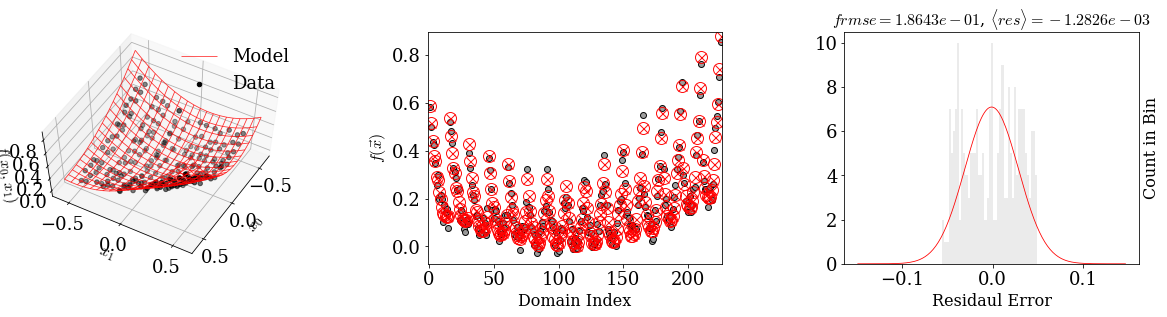

In [20]:
close('all')
x0 = linspace(-0.5,0.5,15)
y0 = array(x0)
u0 = array(x0)
x = x0 + 0.08*(random.random( x0.shape )-0.5)
y = y0 + 0.08*(random.random( y0.shape )-0.5)
X,Y = meshgrid(x,y)
zfun = lambda xx,yy: xx**2 + yy**2 + xx*yy + yy*xx**2

Z = zfun(X,Y) + 0.1*(random.random( X.shape )-0.5)

#
domain,scalar_range = ndflatten( [X,Y], Z )

foo = gmvpfit( domain, scalar_range, verbose = True );
foo.plot();



## Notes

* The most important thing to note here is that we gave the algorithm, ```gmvpfit()```, data within noise, and the algorithm was able to automatically learn the underlying manifold with minimal external input (only a maximum polynomial degree was given in this case).
* I should also point out that positive and negative greedy algorithms were used to select the optimal model. The negative one is needed because the positive algorithm overmodels the space.
* Other variaitons on the greedy approach taken here may be considered in the future. For example, rather than exhausting the positive greedy algorithm before trying the negative one, it may also be effective to stagger the greedy steps: after a new sybol is added, apply a negative greedy process to remove any symbols that the new one makes unnecessary. This will be left for possible future consideration.

# Review/Discussion/Conclusions


#### Review
I have developed a collection of algorithms that is, in principle, capable of automatically modeling any N-Dimensional (scalar) space (real or complex valued) by the automated selection of an underlying polynomial model.

#### Discussion
While the examples above have not explicitly demonstrated application to complex manifolds, we note that there is no mathematical reason (beyond buggy code) while the method does not work in these spaces. I leave examples for complex valued ranges to another notebook.

The code is shown to work well for most likely cases, but it surely is not perfect. It will obviously break if the data is too noisey. It's current encarnation will surely yield biased results if the domain is not samples uniformly. This latter drawback could be fixed by redefining the inner-product space according to data sparcity.

#### Conclusions
While the method developed seems to hinge on polynomial (really multinomial) modeling, one should note that any modeling problem can be well posed as a polynomial fitting problem under the appropriate mapping of the domain and/or range.

It is expect that the methods developed here will be of significant use to current and future modeling efforts.

# Let's Try to Break it

(gmvpfit)>> Now working deg = 1
&& The estimator has changed by -inf
&& Degree tempering will continue.
&& The current boundary is ['1', '0']
&& The current estimator value is 0.730796

(gmvpfit)>> Now working deg = 2
&& The estimator has changed by 0.000000
&& Degree tempering will continue.
&& The current boundary is ['1', '0']
&& The current estimator value is 0.730796

(gmvpfit)>> Now working deg = 3
&& The estimator has changed by -0.107141
&& Degree tempering will continue.
&& The current boundary is ['1', '0', '011', '001', '000', '111']
&& The current estimator value is 0.623655

(gmvpfit)>> Now working deg = 4
&& The estimator has changed by 0.000000
&& Degree tempering will continue.
&& The current boundary is ['1', '0', '011', '001', '000', '111']
&& The current estimator value is 0.623655

(gmvpfit)>> Now working deg = 5
&& The estimator has changed by -0.273281
&& Degree tempering will continue.
&& The current boundary is ['1', '0', '00011', '00111', '001', '011', '111', '

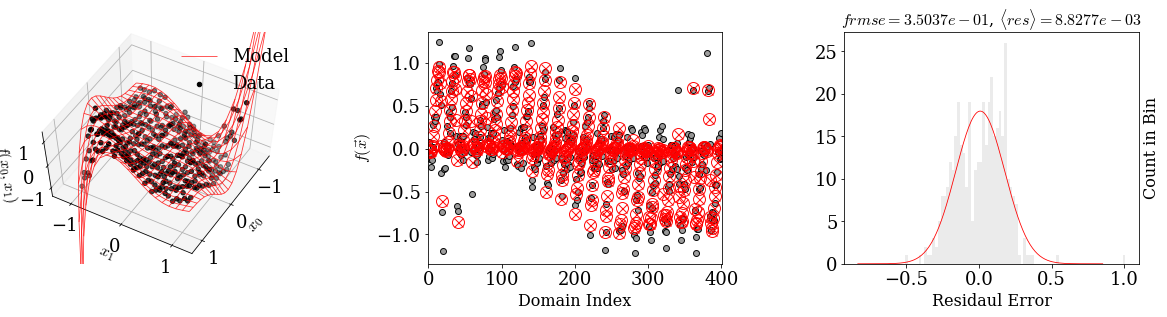

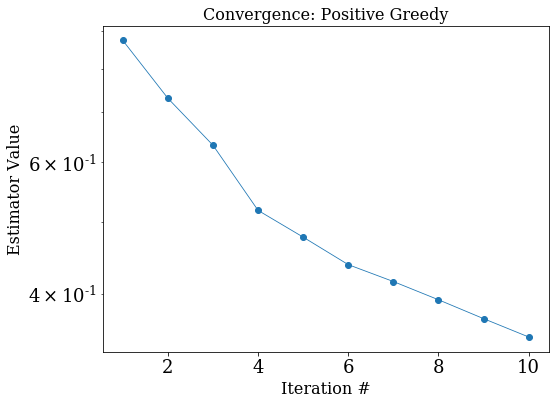

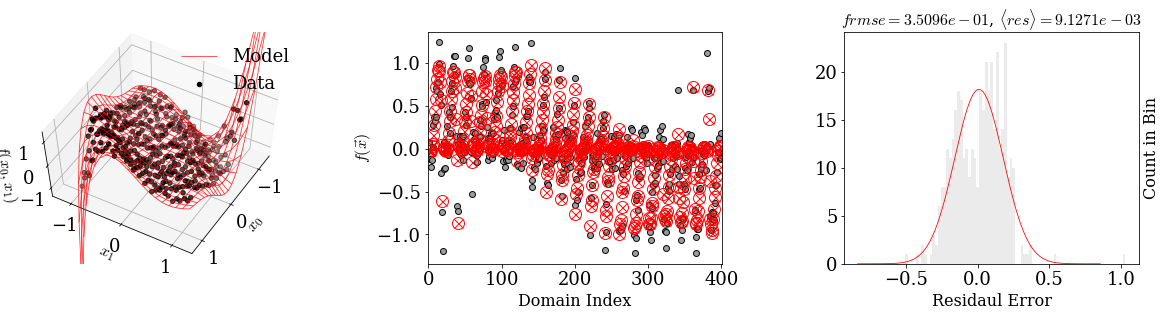

>> min_estimator = 3.5096e-01
>> "1" was removed from the boundary.
>> As a result, the estimator value changed by 0.000590. The tolerance for this change is 0.020165
>> The current boundary = ['0', '00011', '00111', '001', '011', '111', '00001', '000', '01111']

Iteration #2 (Negative Greedy)
------------------------------------


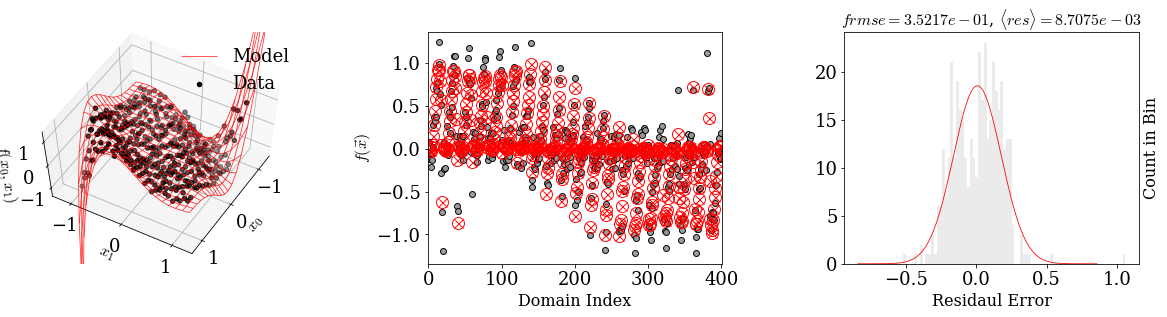

>> min_estimator = 3.5217e-01
>> "0" was removed from the boundary.
>> As a result, the estimator value changed by 0.001791. The tolerance for this change is 0.020165
>> The current boundary = ['00011', '00111', '001', '011', '111', '00001', '000', '01111']

Iteration #3 (Negative Greedy)
------------------------------------


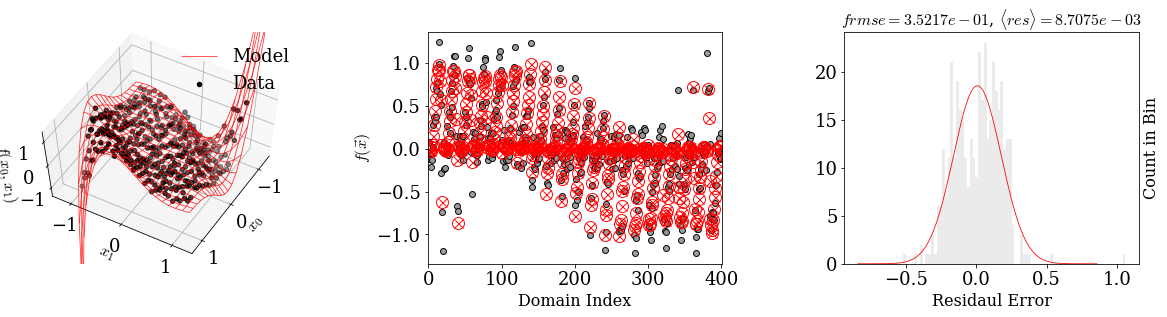

>> min_estimator = 3.7740e-01
>> The current boundary = ['00011', '00111', '001', '011', '111', '00001', '000', '01111']
>> Exiting because |min_est-initial_estimator_value| = |0.377399-0.350375| = |0.027024| > 0.020165.
>> NOTE that the result of the previous iteration will be kept.


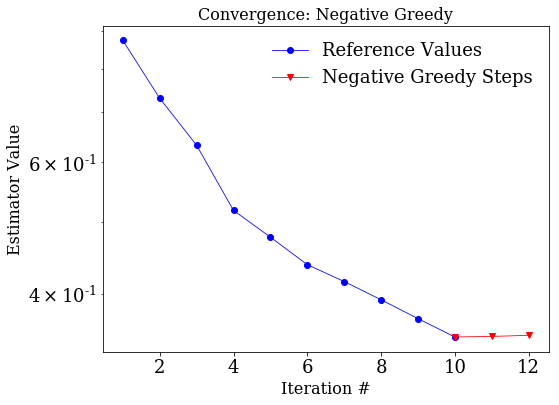


# Negative Greedy Solution:
f = lambda x0,x1: -2.7056e+00*(x0*x0*x1) + 2.5788e+00*(x0*x1*x1) + 6.6872e-01*(x0*x0*x0) + -6.3254e-01*(x1*x1*x1) + -1.1323e+00*(x0*x1*x1*x1*x1) + 3.0437e+00*(x0*x0*x1*x1*x1) + 1.2303e+00*(x0*x0*x0*x0*x1) + -3.0428e+00*(x0*x0*x0*x1*x1)

Fit Information:
----------------------------------------
f = lambda x0,x1: -2.7056e+00*(x0*x0*x1) + 2.5788e+00*(x0*x1*x1) + 6.6872e-01*(x0*x0*x0) + -6.3254e-01*(x1*x1*x1) + -1.1323e+00*(x0*x1*x1*x1*x1) + 3.0437e+00*(x0*x0*x1*x1*x1) + 1.2303e+00*(x0*x0*x0*x0*x1) + -3.0428e+00*(x0*x0*x0*x1*x1)


In [21]:
close('all')
x0 = linspace(-1,1,20)
y0 = array(x0)
u0 = array(x0)
x = x0 + 0.08*(random.random( x0.shape )-0.5)
y = y0 + 0.08*(random.random( y0.shape )-0.5)
X,Y = meshgrid(x,y)
zfun = lambda xx,yy: sin(0.2*pi*(xx-yy)**3) 

Z = zfun(X,Y) + 0.5*(random.random( X.shape )-0.5)

#
domain,scalar_range = ndflatten( [X,Y], Z )

foo = gmvpfit( domain, scalar_range, verbose = True, plot=True, show = True )